In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 2. Load the dataset
df = pd.read_csv("uber.csv")
print("Initial shape:", df.shape)
display(df.head(3))


Initial shape: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [4]:
# 3. Drop missing and duplicate values
df = df.dropna()
df = df.drop_duplicates()

In [5]:
# 4. Filter invalid fares and passenger counts
df = df[df['fare_amount'] > 0]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [6]:
# 5. Convert datetime column
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
# Drop rows where conversion failed
df = df.dropna(subset=['pickup_datetime'])

In [7]:
# 6. Extract datetime features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

In [8]:
display(df.head(3))

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009


In [9]:
# 7. Remove invalid coordinates (assuming NYC boundary)
df = df[
    df['pickup_latitude'].between(40, 42) &
    df['pickup_longitude'].between(-75, -72) &
    df['dropoff_latitude'].between(40, 42) &
    df['dropoff_longitude'].between(-75, -72)
]

In [10]:
# 8. Haversine distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = haversine_distance(
    df['pickup_latitude'],
    df['pickup_longitude'],
    df['dropoff_latitude'],
    df['dropoff_longitude']
)

In [11]:
# Filter distance outliers
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 100)]

print("Shape after cleaning:", df.shape)


Shape after cleaning: (193059, 14)


In [12]:
# 9. Outlier removal for fare_amount using IQR
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]

print("Final shape after cleaning:", df.shape)


Final shape after cleaning: (176543, 14)


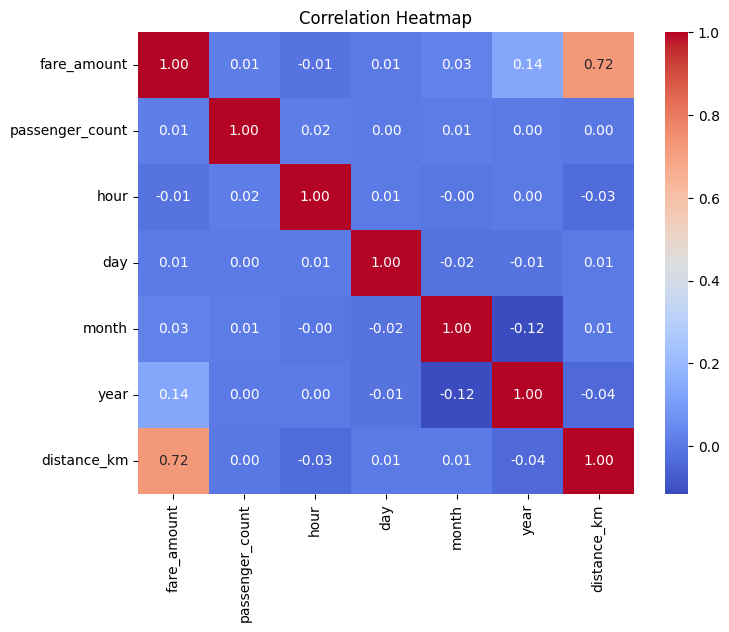

In [13]:
# 10. Correlation Matrix
corr_features = ['fare_amount', 'passenger_count', 'hour', 'day', 'month', 'year', 'distance_km']
correlation = df[corr_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# 11. Features and Target
features = ['passenger_count', 'hour', 'month', 'year', 'distance_km']
X = df[features]
y = df['fare_amount']

In [15]:
# 12. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 13. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

In [ ]:
# 14. Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [19]:
# 15. Evaluation function
def evaluate_model(true, predicted, name):
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    print(f"{name} - R² Score: {r2:.4f}")
    print(f"{name} - RMSE: {rmse:.4f}")
    print()

In [20]:
# 16. Evaluate both models
evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest Regression")

Linear Regression - R² Score: 0.5560
Linear Regression - RMSE: 2.7618

Random Forest Regression - R² Score: 0.7188
Random Forest Regression - RMSE: 2.1979

